In [1]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import StaticRP as SRP
import dtr
import motion
import sim_template as sim
from importlib import reload 
import TSPN

In [2]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [3]:
#If we're feeling it
if False:
    %store -r dt_sys AORP TSPNP tjcps pjcps qBase region pcs pfs pjcps prob_pred_con ccs cfs true_joint_con_fields tjcps

In [53]:
#Setup the communication environment:

#For now, use same channel params, basd on the San Francisco measurements
nPL = 5.2 # per SF data should be in [2, 10]
kPL = -20 # per SF data, [-20, 90]

decorrSH = 2.09    
alpha = 16 # per SF data [4,100]%too high - worse prediction
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5



#6 remote stations
l = 18
l_inner=20
c = np.array([40, 40])

# qBase = np.array([[2,50], [20,50], 
#                   [30, 80], [30, 98],
#                   [30, 20], [30, 2]])

qBase = np.array([[50,2], [50, 20], 
                  [80, 33], [92, 47],
                  [8, 47], [20, 33]])


sub_regions = [[60, 40, np.max(qBase[0:2,1]), np.min(qBase[0:2,1]) ],
               [np.max(qBase[2:4,0])+5, np.min(qBase[2:4,0])-5, np.max(qBase[2:4,1])+5, np.min(qBase[2:4,1])-5],
               [np.max(qBase[4:,0])+5, np.min(qBase[4:,0])-5, np.max(qBase[4:,1])+5, np.min(qBase[4:,1])-5]]



cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 100
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
n=3
p_th = 0.5

bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
els = [0.4/beta, 0.05/beta, 0.05/beta]
print(sub_regions, qBase)

[[60, 40, 20, 2], [99, 77, 52, 28], [25, 3, 52, 28]] [[50  2]
 [50 20]
 [82 33]
 [94 47]
 [ 8 47]
 [20 33]]


In [76]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


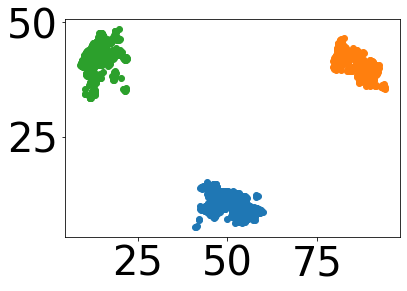

In [77]:
for points in tjcps:
    plt.scatter(points[:,0], points[:,1])

In [78]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)

print(prob_pred_con)

Drawing 360 samples from Channel 1
Completed PredictedChannel 1
Drawing 360 samples from Channel 2
Completed PredictedChannel 2
Drawing 528 samples from Channel 3
Completed PredictedChannel 3
Drawing 528 samples from Channel 4
Completed PredictedChannel 4
Drawing 528 samples from Channel 5
Completed PredictedChannel 5
Drawing 528 samples from Channel 6
Completed PredictedChannel 6
[0.7703488372093024, 0.7968270214943706, 0.7674113009198423]


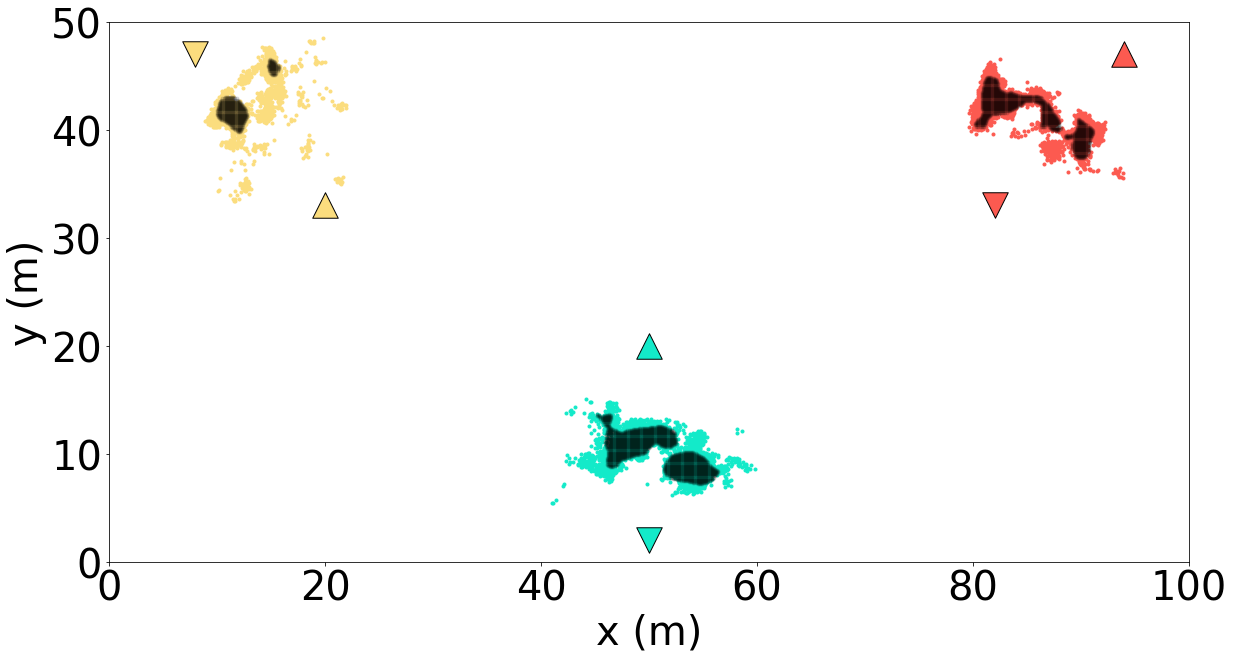

In [79]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.gca().set_aspect("equal")
plt.show()

In [80]:
reload(sim)
sys_traffic = 0.4
els = np.array([0.8, 0.1, 0.1])*sys_traffic/beta
dt_sys = dtr.DTR(pcs, region, els, beta, th = GAMMA_TH, p_th=p_th)
ps = dt_sys.ps

dts_fn = "FIG_asym_tri_policy_comp_dt_sys.pkl"
if False:
    import pickle
    with open(dts_fn, 'wb') as outp:
        pickle.dump(dt_sys, outp)

Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
14 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
17 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
5 total subregions


In [81]:
dts_fn = "FIG_asym_tri_policy_comp_dt_sys.pkl"
if False:
    #load dt_sys from pickle file
    with open(dts_fn, 'rb') as inp:
        dt_sys = pickle.load(inp)

In [82]:
regions = dt_sys.cregions
tspn_min, tspn_argmin = TSPN.TSPN_BF(regions)
x=tspn_argmin[0]

TSPNP={'X':x, 'SEQ':tspn_argmin[1]}

Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 152.07
Elapsed Time: 0.17


In [83]:
reload(sim)
v = 1


plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})

print("Finding AORP")
AORP = sim.calc_AORP(dt_sys, v)
print("Found AORP")
pi = AORP['pi']
S = dtr.XtoS(AORP['X'])
S_cy = dtr.XtoS(TSPNP['X'])
S_cyv = np.zeros(n)
seq = TSPNP['SEQ']
for i in range(n):
    S_cyv[i] = S_cy[seq[i], seq[(i+1)%n]]

#S_i = S @ pi
W_rnd = ps._calc_avg_wait_random(S, pi)
W_cy = ps._calc_avg_wait_cyclic(S_cyv)

#print(S)
P_tilde, pi_tilde = sim.pi_to_P(pi)
print(P_tilde)
S_i = np.diag(P_tilde@S)
print(els)
print(pi)
print(pi_tilde)
print(S_i)
print(W_rnd)
print(W_cy)

Finding AORP
Found AORP
[[0.00000000e+00 4.99999989e-01 5.00000011e-01]
 [9.99499750e-01 0.00000000e+00 5.00250169e-04]
 [9.99499750e-01 5.00250146e-04 0.00000000e+00]]
[5.12 0.64 0.64]
[9.99000000e-01 5.00000021e-04 5.00000044e-04]
[0.49987491 0.25006254 0.25006255]
[43.0774818  43.16448784 43.0154126 ]
81.01651756512545
92.96448833917593


In [132]:
#save off figure data
if False:
    np.savez("FIG_asym_tri_policy_comp__fig_6_data", aorpx = AORP['X'], aorppi = AORP['pi'],
             tspnpx = TSPNP['X'], tspnpseq = TSPNP['SEQ'], tjcps = tjcps, pjcps=pjcps)

In [133]:
if False:
    fig6_data = np.load("FIG_asym_tri_policy_comp__fig_6_data.npz", allow_pickle = True)
    AORP = {"X":fig6_data["aorpx"], "pi":fig6_data["aorppi"]}
    TSPNP = {"X":fig6_data["tspnpx"], "SEQ":fig6_data["tspnpseq"]}
    tjcps = fig6_data["tjcps"]
    pjcps = fig6_data["pjcps"]

[0.32 0.04 0.04] [9.99000000e-01 5.00000021e-04 5.00000044e-04]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

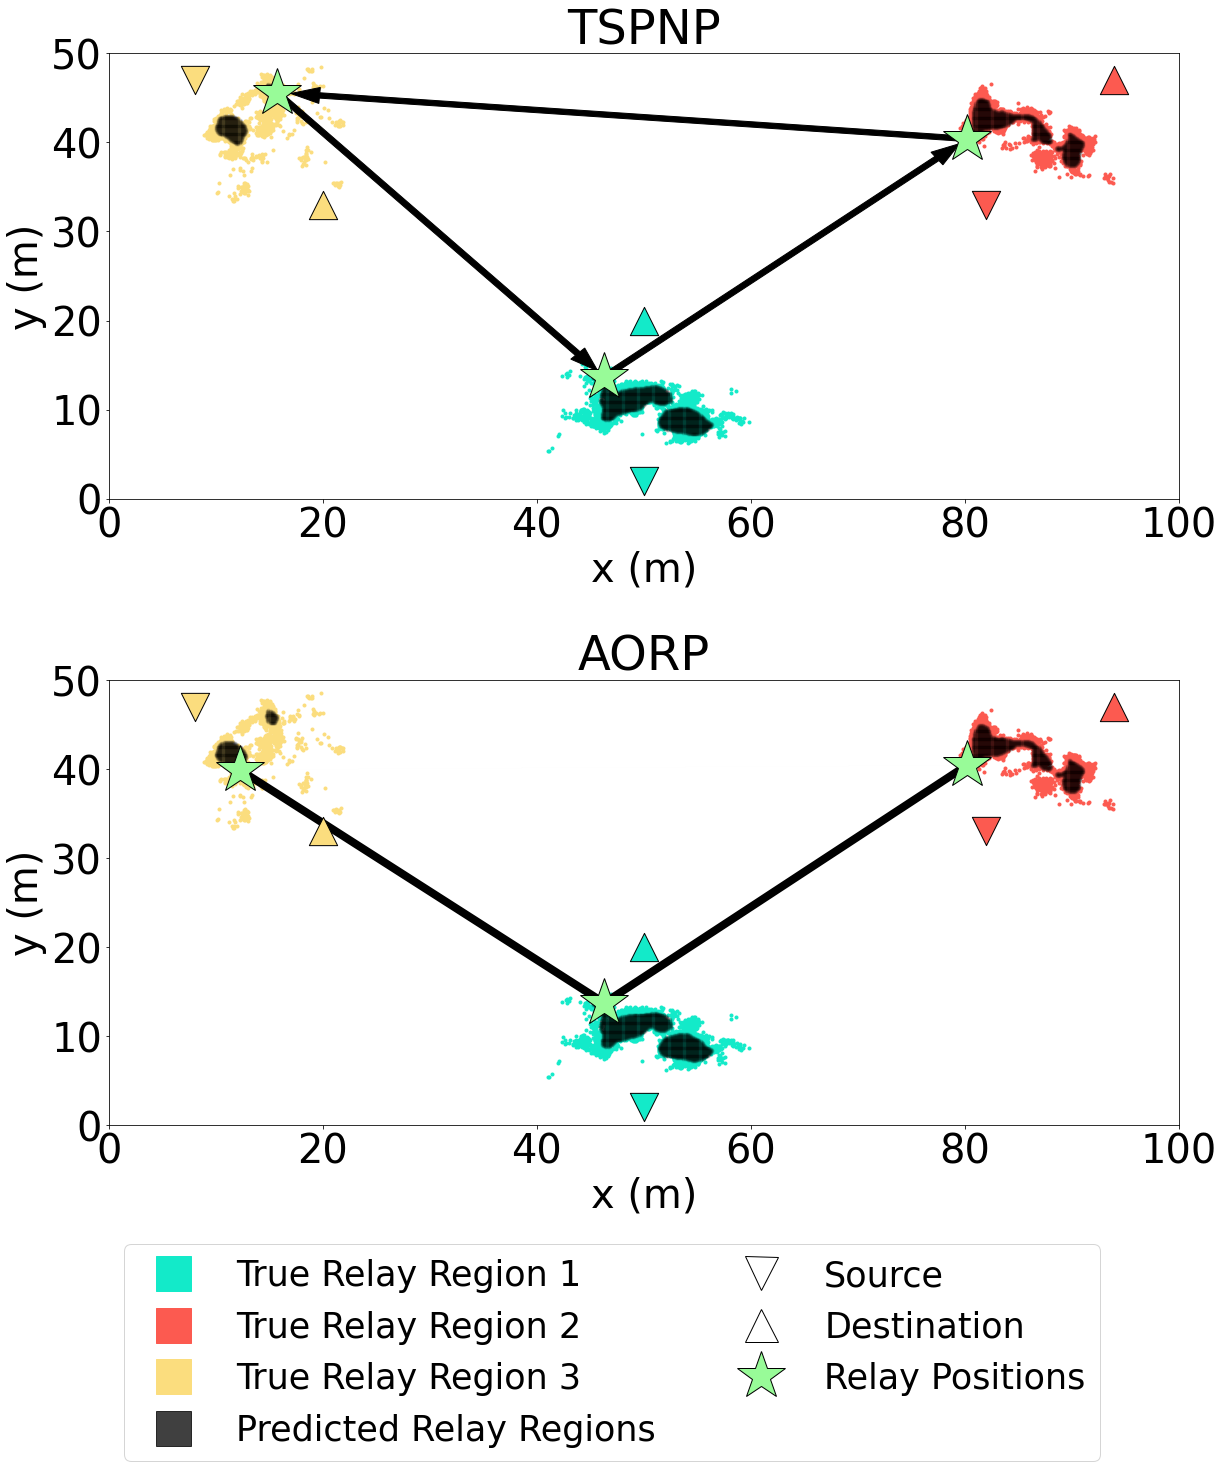

In [141]:
reload(sim)
# sim.plot_AORP_W_TSPN(dt_sys, AORP, TSPNP, tjcps, pjcps, qBase, region, np.array(els)*beta, pi)
sim.plot_AORP_W_TSPN(dt_sys, AORP, TSPNP, tjcps, pjcps, qBase, region, None, None)
plt.tight_layout()
print(np.array(els)*beta, pi)
plt.savefig("asym_tri_TSPNP_v_AORP.png", format='png', bbox_inches='tight')
plt.savefig("asym_tri_TSPNP_v_AORP.eps", format='eps', bbox_inches='tight')

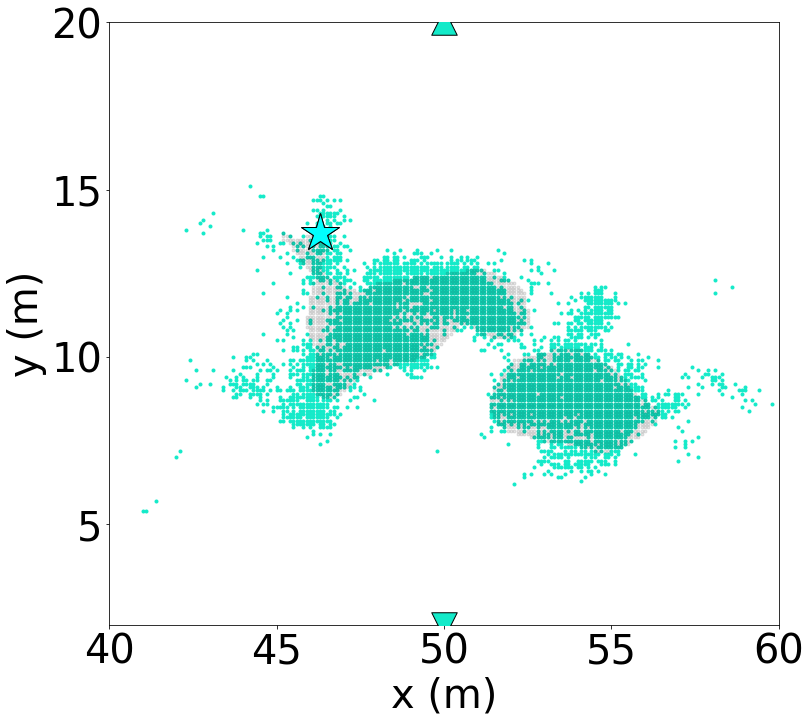

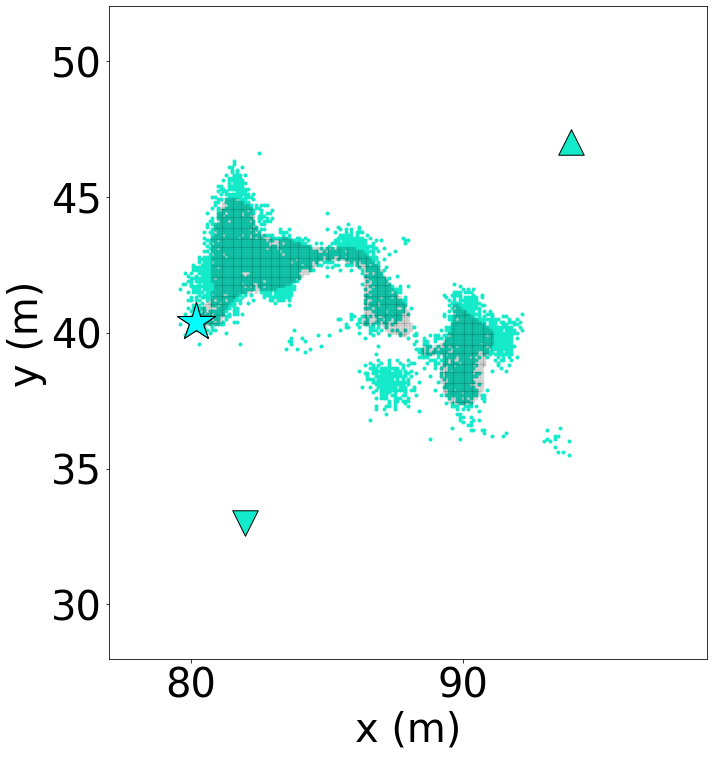

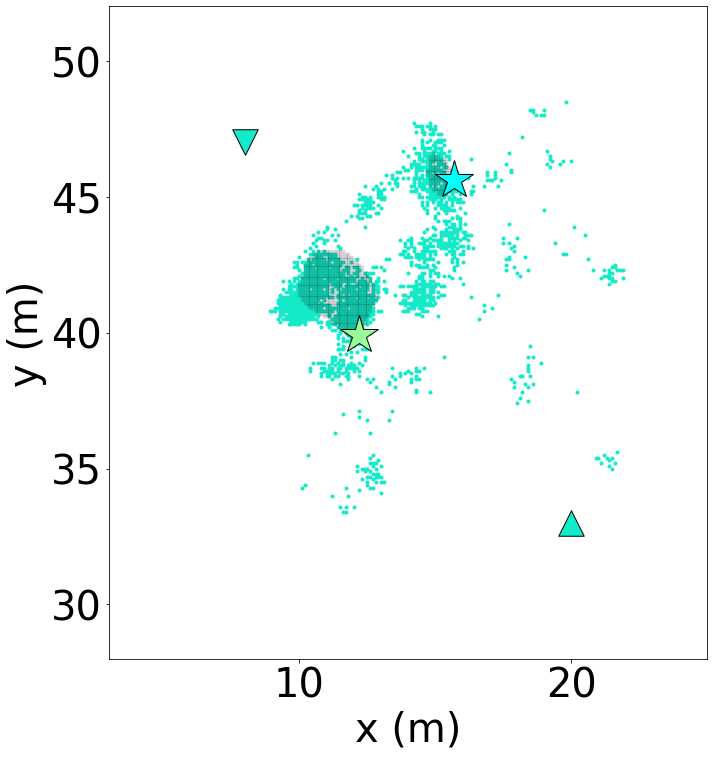

In [116]:
reload(sim)
for i in range(n):
    fig = plt.figure(figsize=(12,12))
#     plt.scatter(tjcps[i][:,0], tjcps[i][:,1])
#     plt.scatter(pjcps[i][:,0], pjcps[i][:,1])
    sim.plotCFwithOverlay(1, [tjcps[i]], [pjcps[i]], qBase[2*i:2*(i+1)], sub_regions[i], ax=plt.gca())
#     plt.scatter(AORP['X'][i][0], AORP['X'][i][1], )
#     print(AORP['X'][i])
#     sim._plot_relay_points(np.array([AORP['X'][i]]), plt.gca())
    X = AORP['X']
    plt.plot(X[i,0], X[i,1], '*', markersize=40, markerfacecolor='palegreen', markeredgecolor='k', zorder = 101)
    
    X = TSPNP['X']
    plt.plot(X[i,0], X[i,1], '*', markersize=40, markerfacecolor='cyan', markeredgecolor='k', zorder = 101)
    
    subregion = sub_regions[i]
    plt.xlim(subregion[1], subregion[0])
    plt.ylim(subregion[3], subregion[2])
    plt.gca().set_aspect("equal")
    plt.show()

In [86]:
reload(sim)
hrs = 2
mins = 0
seconds = 0
print('Velocity = %f'%(v))
motion_power = motion.LinearMotionPower(7.2, 0.29, v)
sim.run_sims(dt_sys.ps, AORP, TSPNP, hrs, mins, seconds, motion_power, MOBILE_TX_POWER.W, v)
print('done')

Velocity = 1.000000
Theotretical MB serviced: 46080.000000000015
Theoretical Energy Consumption (J): 32644.799999999992
	Th. WT	WT	E (J)	MBS	MBR
AORP	81.02	80.76	33010.32	45653.15	637.10
Tab	---	66.05	32985.77	45611.45	535.95
TSPN	---	92.89	33163.97	45264.75	893.95
done
